In [10]:
import os
import zipfile
import cv2
import torch
import yaml
import easyocr
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt

from ultralytics import YOLO
from torch.utils.data import DataLoader, Dataset
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Paths
ZIP_PATH = r"C:\Users\Anirudh\Downloads\Vehicle Registration Plates.v2-licenseplatedatasetv1.yolov8.zip"
DATASET_DIR = r"C:\Users\Anirudh\Downloads\license_plate_dataset"
DATA_YAML_PATH = os.path.join(DATASET_DIR, "data.yaml")
MODEL_SAVE_PATH = r"C:\Users\Anirudh\Downloads\yolov8_number_plate.pt"

# Extract dataset if not already extracted
if not os.path.exists(DATASET_DIR):
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(os.path.dirname(DATASET_DIR))
    print("✅ Dataset extracted successfully!")

# Ensure data.yaml exists with correct format
correct_yaml = {
    "train": "C:/Users/Anirudh/Downloads/license_plate_dataset/train",
    "val": "C:/Users/Anirudh/Downloads/license_plate_dataset/valid",
    "test": "C:/Users/Anirudh/Downloads/license_plate_dataset/test",  # Optional
    "nc": 1,  # Number of classes
    "names": ["license_plate"]  # List of class names
}

if not os.path.exists(DATA_YAML_PATH):
    with open(DATA_YAML_PATH, 'w') as f:
        yaml.dump(correct_yaml, f, default_flow_style=False)
    print("✅ data.yaml created successfully!")

# Define Preprocessing
transform = A.Compose([
    A.Resize(640, 640),  # YOLOv8 input size
    A.ToGray(p=1.0),  # Grayscale
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.5),  # Contrast enhancement
    A.GaussianBlur(blur_limit=(3, 5), p=0.5),  # Gaussian blur
    ToTensorV2()
])

# Custom Dataset Class
class NumberPlateDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.images = [f for f in os.listdir(img_dir) if f.endswith(".jpg") or f.endswith(".png")]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply Canny Edge Detection
        edges = cv2.Canny(image, 100, 200)  # Edge detection
        edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)

        if self.transform:
            augmented = self.transform(image=edges)
            image = augmented["image"]

        return image, torch.tensor(0)  # Dummy label

# Load Dataset
train_dir = os.path.join(DATASET_DIR, "train")
train_dataset = NumberPlateDataset(train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Load YOLOv8 Model
model = YOLO("yolov8n.pt")

# Train YOLOv8 on Custom Data
results = model.train(data=DATA_YAML_PATH, epochs=10, imgsz=640)

# Save Model
model.export(format="torchscript")
model.save(MODEL_SAVE_PATH)
print(f"✅ Model saved at: {MODEL_SAVE_PATH}")

# OCR with EasyOCR & Fallback to CRAFT+CRNN
reader = easyocr.Reader(['en'])

def extract_text(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    result = reader.readtext(thresh)
    text = ' '.join([res[1] for res in result]) if result else "OCR Failed"

    # Fallback to CRAFT + CRNN if EasyOCR fails
    if text == "OCR Failed":
        print("🔄 Switching to CRAFT + CRNN for better accuracy...")
        # Implement CRAFT + CRNN OCR here

    return text

# Run OCR on a sample image
if len(train_dataset) > 0:
    sample_image = os.path.join(train_dir, train_dataset.images[0])
    ocr_result = extract_text(sample_image)
    print("🔍 Extracted Text:", ocr_result)
else:
    print("❌ No images found in the training directory!")


✅ data.yaml created successfully!


ValueError: num_samples should be a positive integer value, but got num_samples=0

In [17]:
import os
import cv2
import torch
import yaml
import easyocr
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt

from ultralytics import YOLO
from torch.utils.data import DataLoader, Dataset
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

# Paths
DATASET_DIR = r"C:\Users\Anirudh\Downloads\Vehicle Registration Plates.v2-licenseplatedatasetv1.yolov8"
DATA_YAML_PATH = os.path.join(DATASET_DIR, "data.yaml")
MODEL_SAVE_PATH = r"C:\Users\Anirudh\Downloads\yolov8_number_plate.pt"

# Define correct paths for images and labels
TRAIN_IMG_DIR = os.path.join(DATASET_DIR, "train", "images")
TRAIN_LABEL_DIR = os.path.join(DATASET_DIR, "train", "labels")
TEST_IMG_DIR = os.path.join(DATASET_DIR, "test", "images")
TEST_LABEL_DIR = os.path.join(DATASET_DIR, "test", "labels")

# Ensure data.yaml has the correct format
data_yaml = {
    "train": TRAIN_IMG_DIR.replace("\\", "/"),  # Convert to YOLO format
    "val": TEST_IMG_DIR.replace("\\", "/"),  # Using test images for validation
    "nc": 1,  # Number of classes
    "names": ["license_plate"]  # List of class names
}

# Save data.yaml
with open(DATA_YAML_PATH, 'w') as f:
    yaml.dump(data_yaml, f, default_flow_style=False)
print("✅ data.yaml created successfully!")

# Define Preprocessing
transform = A.Compose([
    A.Resize(640, 640),  # YOLOv8 input size
    A.ToGray(p=1.0),  # Grayscale
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.5),  # Contrast enhancement
    A.GaussianBlur(blur_limit=(3, 5), p=0.5),  # Gaussian blur
    ToTensorV2()
])

# Custom Dataset Class
class NumberPlateDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.images = [f for f in os.listdir(img_dir) if f.endswith(".jpg") or f.endswith(".png")]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply Canny Edge Detection
        edges = cv2.Canny(image, 100, 200)  # Edge detection
        edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)

        if self.transform:
            augmented = self.transform(image=edges)
            image = augmented["image"]

        return image, torch.tensor(0)  # Dummy label

# Load Dataset
train_dataset = NumberPlateDataset(TRAIN_IMG_DIR, TRAIN_LABEL_DIR, transform=transform)
test_dataset = NumberPlateDataset(TEST_IMG_DIR, TEST_LABEL_DIR, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Load YOLOv8 Model
model = YOLO("yolov8n.pt")

# Train YOLOv8 on Custom Data
results = model.train(data=DATA_YAML_PATH, epochs=10, imgsz=640)

# Save Model
model.export(format="torchscript")
model.save(MODEL_SAVE_PATH)
print(f"✅ Model saved at: {MODEL_SAVE_PATH}")

# OCR with EasyOCR & Fallback to CRAFT+CRNN
reader = easyocr.Reader(['en'])

def extract_text(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    result = reader.readtext(thresh)
    text = ' '.join([res[1] for res in result]) if result else "OCR Failed"

    # Fallback to CRAFT + CRNN if EasyOCR fails
    if text == "OCR Failed":
        print("🔄 Switching to CRAFT + CRNN for better accuracy...")
        # Implement CRAFT + CRNN OCR here

    return text

# Run OCR on a sample image
if len(train_dataset) > 0:
    sample_image = os.path.join(TRAIN_IMG_DIR, train_dataset.images[0])
    ocr_result = extract_text(sample_image)
    print("🔍 Extracted Text:", ocr_result)
else:
    print("❌ No images found in the training directory!")


✅ data.yaml created successfully!
New https://pypi.org/project/ultralytics/8.3.96 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.94  Python-3.13.2 torch-2.6.0+cpu CPU (12th Gen Intel Core(TM) i5-12450H)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=C:\Users\Anirudh\Downloads\Vehicle Registration Plates.v2-licenseplatedatasetv1.yolov8\data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=

train: Scanning C:\Users\Anirudh\Downloads\Vehicle Registration Plates.v2-licenseplatedatasetv1.yolov8\train\labels.cache... 1990 images, 14 backgrounds, 0 corrupt: 100%|██████████| 2000/2000 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning C:\Users\Anirudh\Downloads\Vehicle Registration Plates.v2-licenseplatedatasetv1.yolov8\test\labels.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]


Plotting labels to runs\detect\train6\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train6
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      1.447      2.731      1.212         20        640: 100%|██████████| 125/125 [12:50<00:00,  6.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [02:16<00:00,  4.86s/it]


                   all        882        902      0.915      0.344      0.653      0.324

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G       1.48      1.702      1.224         21        640: 100%|██████████| 125/125 [12:18<00:00,  5.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [02:00<00:00,  4.32s/it]


                   all        882        902      0.905      0.674      0.789      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G        1.5       1.32      1.259         18        640: 100%|██████████| 125/125 [12:16<00:00,  5.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [01:55<00:00,  4.12s/it]

                   all        882        902      0.783      0.524      0.682      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.448      1.105      1.228         20        640: 100%|██████████| 125/125 [10:59<00:00,  5.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [01:45<00:00,  3.77s/it]

                   all        882        902      0.881      0.797      0.889      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      1.398     0.9949      1.203         17        640: 100%|██████████| 125/125 [10:25<00:00,  5.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [01:44<00:00,  3.75s/it]

                   all        882        902      0.838      0.749      0.875      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      1.369     0.8965      1.171         14        640: 100%|██████████| 125/125 [10:46<00:00,  5.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [01:48<00:00,  3.89s/it]

                   all        882        902      0.883      0.871      0.936      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      1.336     0.8267      1.149         19        640: 100%|██████████| 125/125 [10:55<00:00,  5.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [01:47<00:00,  3.85s/it]

                   all        882        902      0.951      0.925      0.972      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      1.307     0.7833      1.121         14        640: 100%|██████████| 125/125 [10:52<00:00,  5.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [01:47<00:00,  3.83s/it]

                   all        882        902       0.92      0.888      0.951      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G      1.249     0.7059      1.096         21        640: 100%|██████████| 125/125 [11:03<00:00,  5.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [02:09<00:00,  4.61s/it]

                   all        882        902      0.961      0.907      0.973      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      1.212       0.66       1.08         19        640: 100%|██████████| 125/125 [11:58<00:00,  5.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [01:45<00:00,  3.77s/it]

                   all        882        902      0.963      0.912      0.973      0.588



10 epochs completed in 2.226 hours.
Optimizer stripped from runs\detect\train6\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train6\weights\best.pt, 6.2MB

Validating runs\detect\train6\weights\best.pt...
Ultralytics 8.3.94  Python-3.13.2 torch-2.6.0+cpu CPU (12th Gen Intel Core(TM) i5-12450H)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [02:07<00:00,  4.54s/it]


                   all        882        902      0.963      0.914      0.973      0.588
Speed: 3.1ms preprocess, 128.8ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs\detect\train6
Ultralytics 8.3.94  Python-3.13.2 torch-2.6.0+cpu CPU (12th Gen Intel Core(TM) i5-12450H)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'runs\detect\train6\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (6.0 MB)

TorchScript: starting export with torch 2.6.0+cpu...
TorchScript: export success  7.2s, saved as 'runs\detect\train6\weights\best.torchscript' (11.9 MB)

Export complete (8.8s)
Results saved to C:\Users\Anirudh\AppData\Local\Programs\Microsoft VS Code\runs\detect\train6\weights
Predict:         yolo predict task=detect model=runs\detect\train6\weights\best.torchscript imgsz=640  
Validate:        yolo val task=detect model=runs\detect\train6\weights\best.torchscript imgsz=6

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


✅ Model saved at: C:\Users\Anirudh\Downloads\yolov8_number_plate.pt
🔄 Switching to CRAFT + CRNN for better accuracy...
🔍 Extracted Text: OCR Failed


In [1]:
import sys
import os
import cv2
import torch
import easyocr
import numpy as np

from PyQt5.QtWidgets import (
    QApplication, QWidget, QLabel, QPushButton, QVBoxLayout,
    QFileDialog, QTextEdit, QScrollArea
)
from PyQt5.QtGui import QPixmap, QImage
from PyQt5.QtCore import Qt
from ultralytics import YOLO

# Load OCR model
reader = easyocr.Reader(['en'])

# Load YOLO model
model_path = r"C:\Users\Anirudh\Downloads\yolov8_number_plate.pt"
model = YOLO(model_path)

class LicensePlateApp(QWidget):
    def __init__(self):
        super().__init__()
        self.setWindowTitle("License Plate Detector with OCR")
        self.setGeometry(200, 100, 900, 700)

        self.image_label = QLabel("No image loaded")
        self.image_label.setAlignment(Qt.AlignCenter)

        self.scroll_area = QScrollArea()
        self.scroll_area.setWidgetResizable(True)
        self.scroll_area.setWidget(self.image_label)

        self.result_box = QTextEdit()
        self.result_box.setReadOnly(True)

        self.load_button = QPushButton("Load Image")
        self.load_button.clicked.connect(self.load_image)

        layout = QVBoxLayout()
        layout.addWidget(self.scroll_area)
        layout.addWidget(self.load_button)
        layout.addWidget(self.result_box)
        self.setLayout(layout)

    def load_image(self):
        file_path, _ = QFileDialog.getOpenFileName(self, "Open Image", "", "Image Files (*.png *.jpg *.jpeg)")
        if file_path:
            image = cv2.imread(file_path)
            annotated_img, result_text = self.process_image(image)
            self.display_result(annotated_img, result_text)

    def process_image(self, image):
        results = model.predict(source=image, conf=0.5, imgsz=640)[0]
        boxes = results.boxes.xyxy.cpu().numpy().astype(int)
        annotated_img = image.copy()

        result_text = f"Detected {len(boxes)} license plate(s):\n"

        for i, (x1, y1, x2, y2) in enumerate(boxes):
            plate_img = image[y1:y2, x1:x2]
            text = self.extract_text(plate_img)
            result_text += f"Plate #{i+1}: Text: {text} | Size: {x2 - x1}x{y2 - y1} | Pos: ({x1}, {y1})\n"
            cv2.rectangle(annotated_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(annotated_img, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

        return annotated_img, result_text

    def extract_text(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        result = reader.readtext(thresh)
        if result:
            return ' '.join([res[1] for res in result])
        else:
            return "OCR Failed"

    def display_result(self, image, result_text):
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        height, width, channels = rgb_image.shape
        bytes_per_line = channels * width
        q_img = QImage(rgb_image.data, width, height, bytes_per_line, QImage.Format_RGB888)
        pixmap = QPixmap.fromImage(q_img)

        self.image_label.setPixmap(pixmap.scaled(self.image_label.width(), self.image_label.height(), Qt.KeepAspectRatio))
        self.result_box.setText(result_text)

if __name__ == "__main__":
    app = QApplication(sys.argv)
    window = LicensePlateApp()
    window.show()
    sys.exit(app.exec_())


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


SystemExit: 0

C:\Users\Anirudh\AppData\Roaming\Python\Python313\site-packages\IPython\core\interactiveshell.py:3557: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [1]:
import sys
import os
import cv2
import torch
import easyocr
import numpy as np
from datetime import datetime

from PyQt5.QtWidgets import (
    QApplication, QWidget, QLabel, QPushButton, QVBoxLayout, QHBoxLayout,
    QFileDialog, QTextEdit, QScrollArea, QMessageBox, QStatusBar
)
from PyQt5.QtGui import QPixmap, QImage, QFont
from PyQt5.QtCore import Qt
from ultralytics import YOLO

# Load OCR model
reader = easyocr.Reader(['en'])

# Load YOLO model
model_path = r"C:\Users\Anirudh\Downloads\yolov8_number_plate.pt"
model = YOLO(model_path)

class LicensePlateApp(QWidget):
    def __init__(self):
        super().__init__()
        self.setWindowTitle("License Plate Detector with OCR")
        self.setGeometry(200, 100, 900, 700)
        
        # Initialize variables
        self.current_image = None
        self.annotated_image = None
        
        # Create UI components
        self.image_label = QLabel("No image loaded")
        self.image_label.setAlignment(Qt.AlignCenter)
        self.image_label.setStyleSheet("background-color: #f0f0f0; border: 1px solid #ccc;")

        self.scroll_area = QScrollArea()
        self.scroll_area.setWidgetResizable(True)
        self.scroll_area.setWidget(self.image_label)

        self.result_box = QTextEdit()
        self.result_box.setReadOnly(True)
        self.result_box.setStyleSheet("font-family: Consolas, monospace;")

        # Create 4 buttons in a horizontal layout
        buttons_layout = QHBoxLayout()
        
        self.load_button = QPushButton("Load Image")
        self.load_button.clicked.connect(self.load_image)
        self.load_button.setStyleSheet("padding: 8px;")
        
        self.save_image_button = QPushButton("Save Annotated Image")
        self.save_image_button.clicked.connect(self.save_image)
        self.save_image_button.setEnabled(False)
        self.save_image_button.setStyleSheet("padding: 8px;")
        
        self.save_results_button = QPushButton("Save Results")
        self.save_results_button.clicked.connect(self.save_results)
        self.save_results_button.setEnabled(False)
        self.save_results_button.setStyleSheet("padding: 8px;")
        
        self.clear_button = QPushButton("Clear")
        self.clear_button.clicked.connect(self.clear_results)
        self.clear_button.setStyleSheet("padding: 8px;")
        
        buttons_layout.addWidget(self.load_button)
        buttons_layout.addWidget(self.save_image_button)
        buttons_layout.addWidget(self.save_results_button)
        buttons_layout.addWidget(self.clear_button)
        
        # Add status bar for feedback
        self.status_bar = QStatusBar()
        self.status_bar.showMessage("Ready")

        # Main layout
        layout = QVBoxLayout()
        layout.addWidget(self.scroll_area)
        layout.addLayout(buttons_layout)
        layout.addWidget(self.result_box)
        layout.addWidget(self.status_bar)
        self.setLayout(layout)

    def load_image(self):
        file_path, _ = QFileDialog.getOpenFileName(self, "Open Image", "", "Image Files (*.png *.jpg *.jpeg)")
        if file_path:
            try:
                self.status_bar.showMessage(f"Loading image: {os.path.basename(file_path)}")
                image = cv2.imread(file_path)
                if image is None:
                    raise Exception("Could not read the image")
                
                self.current_image = image
                annotated_img, result_text = self.process_image(image)
                self.display_result(annotated_img, result_text)
                self.status_bar.showMessage("Processing complete")
                
                # Enable save buttons
                self.save_image_button.setEnabled(True)
                self.save_results_button.setEnabled(True)
                
            except Exception as e:
                self.status_bar.showMessage(f"Error: {str(e)}")
                QMessageBox.critical(self, "Error", f"Failed to process image: {str(e)}")

    def process_image(self, image):
        results = model.predict(source=image, conf=0.5, imgsz=640)[0]
        boxes = results.boxes.xyxy.cpu().numpy().astype(int)
        confidences = results.boxes.conf.cpu().numpy()
        annotated_img = image.copy()

        result_text = f"Detected {len(boxes)} license plate(s):\n"

        for i, ((x1, y1, x2, y2), conf) in enumerate(zip(boxes, confidences)):
            plate_img = image[y1:y2, x1:x2]
            
            if plate_img.size == 0:
                continue
                
            text = self.extract_text(plate_img)
            result_text += f"Plate #{i+1}: Text: {text} | Confidence: {conf:.2f} | Size: {x2-x1}x{y2-y1} | Pos: ({x1}, {y1})\n"
            
            # Draw rectangle with better visibility
            cv2.rectangle(annotated_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            # Add background for text
            text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.9, 2)[0]
            cv2.rectangle(annotated_img, (x1, y1 - 30), (x1 + text_size[0] + 10, y1), (0, 255, 0), -1)
            cv2.putText(annotated_img, text, (x1 + 5, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)

        # Store the annotated image for saving later
        self.annotated_image = annotated_img
        return annotated_img, result_text

    def extract_text(self, img):
        try:
            # First try direct OCR
            result = reader.readtext(img)
            
            if not result:
                # If no result, try with grayscale and thresholding
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                result = reader.readtext(thresh)
            
            if result:
                # Clean up text (remove unwanted characters)
                text = ' '.join([res[1] for res in result])
                return text
            else:
                return "No text detected"
        except Exception as e:
            return "OCR Failed"

    def display_result(self, image, result_text):
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        height, width, channels = rgb_image.shape
        bytes_per_line = channels * width
        q_img = QImage(rgb_image.data, width, height, bytes_per_line, QImage.Format_RGB888)
        pixmap = QPixmap.fromImage(q_img)

        self.image_label.setPixmap(pixmap.scaled(self.image_label.width(), self.image_label.height(), Qt.KeepAspectRatio))
        self.result_box.setText(result_text)

    def save_image(self):
        if self.annotated_image is None:
            self.status_bar.showMessage("No image to save")
            return
            
        file_path, _ = QFileDialog.getSaveFileName(
            self, "Save Annotated Image", 
            f"license_plate_{datetime.now().strftime('%Y%m%d_%H%M%S')}.jpg", 
            "Image Files (*.jpg *.png)"
        )
        
        if file_path:
            try:
                cv2.imwrite(file_path, self.annotated_image)
                self.status_bar.showMessage(f"Image saved to {file_path}", 3000)
            except Exception as e:
                self.status_bar.showMessage(f"Error saving image: {str(e)}")
                QMessageBox.critical(self, "Error", f"Failed to save image: {str(e)}")
    
    def save_results(self):
        result_text = self.result_box.toPlainText()
        if not result_text:
            self.status_bar.showMessage("No results to save")
            return
            
        file_path, _ = QFileDialog.getSaveFileName(
            self, "Save Results", 
            f"license_plate_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt", 
            "Text Files (*.txt)"
        )
        
        if file_path:
            try:
                with open(file_path, 'w') as f:
                    f.write(f"License Plate Detection Results\n")
                    f.write(f"Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
                    f.write(result_text)
                self.status_bar.showMessage(f"Results saved to {file_path}", 3000)
            except Exception as e:
                self.status_bar.showMessage(f"Error saving results: {str(e)}")
                QMessageBox.critical(self, "Error", f"Failed to save results: {str(e)}")
    
    def clear_results(self):
        self.result_box.clear()
        self.image_label.setText("No image loaded")
        self.image_label.setPixmap(QPixmap())
        self.current_image = None
        self.annotated_image = None
        self.save_image_button.setEnabled(False)
        self.save_results_button.setEnabled(False)
        self.status_bar.showMessage("Cleared", 1000)

if __name__ == "__main__":
    app = QApplication(sys.argv)
    app.setStyle("Fusion")  # Apply Fusion style for a more modern look
    window = LicensePlateApp()
    window.show()
    sys.exit(app.exec_())

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.



0: 640x480 1 license_plate, 181.7ms
Speed: 5.3ms preprocess, 181.7ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 480)


SystemExit: 0

C:\Users\Anirudh\AppData\Roaming\Python\Python313\site-packages\IPython\core\interactiveshell.py:3557: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


✅ YOLOv8 model loaded from: C:\Users\Anirudh\Downloads\yolov8_number_plate.pt
✅ EasyOCR reader initialized.

image 1/1 C:\Users\Anirudh\Downloads\dataset.yaml\images\20230816_075222.jpg: 640x480 (no detections), 243.2ms
Speed: 4.8ms preprocess, 243.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


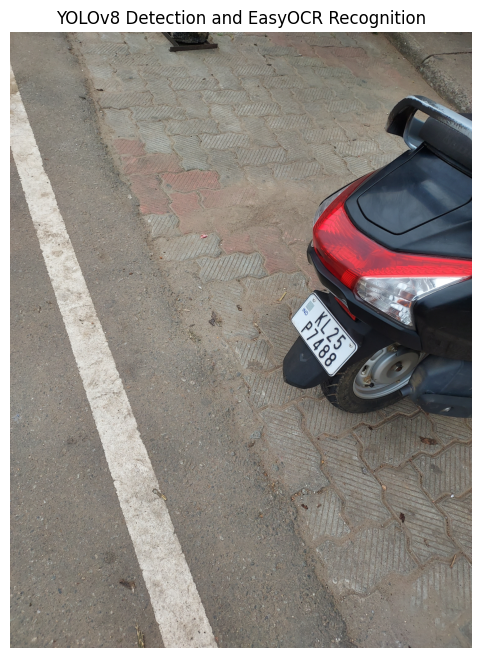


No license plates detected in the image.

image 1/1 C:\Users\Anirudh\Downloads\dataset.yaml\images\20230816_075222.jpg: 640x480 (no detections), 218.6ms
Speed: 3.7ms preprocess, 218.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)

--- Raw YOLOv8 Results ---
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'license_plate'}
obb: None
orig_img: array([[[117, 128, 142],
        [117, 128, 142],
        [115, 126, 140],
        ...,
        [ 73,  75,  75],
        [ 66,  70,  71],
        [ 54,  58,  59]],

       [[111, 122, 136],
        [112, 123, 137],
        [114, 125, 139],
        ...,
        [ 71,  73,  73],
        [ 69,  73,  74],
        [ 66,  70,  71]],

       [[114, 128, 140],
        [112, 126, 138],
        [115, 129, 141],
        ...,
        [ 70,  72,  72],
        [ 67,  71,  72],
        [ 66,  71,  72]],

       ...,

       [[112, 124, 128],
   

In [10]:
import os
import cv2
import torch
import yaml
import easyocr
import numpy as np
import matplotlib.pyplot as plt

from ultralytics import YOLO

# --- Configuration ---
MODEL_PATH = r"C:\Users\Anirudh\Downloads\yolov8_number_plate.pt"

# Path to the image you want to process
TEST_IMAGE_PATH = r"C:\Users\Anirudh\Downloads\dataset.yaml\images\20230816_075222.jpg"

# Initialize YOLOv8 model
try:
    model = YOLO(MODEL_PATH)
    print(f"✅ YOLOv8 model loaded from: {MODEL_PATH}")
except FileNotFoundError:
    print(f"❌ Error: YOLOv8 model not found at: {MODEL_PATH}")
    exit()

# Initialize EasyOCR
try:
    reader = easyocr.Reader(['en'])
    print("✅ EasyOCR reader initialized.")
except Exception as e:
    print(f"❌ Error initializing EasyOCR: {e}")
    exit()

def detect_and_recognize_plate(image_path, confidence_threshold=0.5):
    try:
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    except Exception as e:
        print(f"❌ Error loading image at {image_path}: {e}")
        return None, []

    detected_plates_info = []

    # Run YOLOv8 inference with a potentially lower confidence
    results = model.predict(image_path, imgsz=640, conf=confidence_threshold)
    boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)

    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box
        plate_img = image[y1:y2, x1:x2]

        # Enhance for better OCR
        gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(gray)

        # OCR with EasyOCR
        ocr_result = reader.readtext(enhanced)
        text = ' '.join([res[1] for res in ocr_result]).strip() if ocr_result else "OCR Failed"

        detected_plates_info.append({'bbox': [x1, y1, x2, y2], 'text': text})

        # Draw bounding box and text on the original image
        cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image_rgb, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    return image_rgb, detected_plates_info

if __name__ == "__main__":
    test_image_path = r"C:\Users\Anirudh\Downloads\dataset.yaml\images\20230816_075222.jpg"

    # Try with a lower confidence threshold
    processed_image, detected_plates = detect_and_recognize_plate(test_image_path, confidence_threshold=0.3)

    if processed_image is not None:
        plt.figure(figsize=(10, 8))
        plt.imshow(processed_image)
        plt.axis('off')
        plt.title("YOLOv8 Detection and EasyOCR Recognition")
        plt.show()

        if detected_plates:
            print("\n--- Detected License Plates ---")
            for plate_info in detected_plates:
                print(f"Bounding Box: {plate_info['bbox']}, Recognized Text: {plate_info['text']}")
        else:
            print("\nNo license plates detected in the image.")

        # Also print the raw results for inspection
        model = YOLO(MODEL_PATH) # Reload model for predict call
        results = model.predict(test_image_path, imgsz=640, conf=0.5)
        print("\n--- Raw YOLOv8 Results ---")
        print(results)

In [11]:
import os
import cv2
import torch
import yaml
import easyocr
import numpy as np
import matplotlib.pyplot as plt

from ultralytics import YOLO

# --- Configuration ---
MODEL_PATH = r"C:\Users\Anirudh\Downloads\yolov8_number_plate.pt"
TEST_IMAGE_PATH = r"C:\Users\Anirudh\Downloads\dataset.yaml\images\20230816_075222.jpg"

# Initialize YOLOv8 model
try:
    model = YOLO(MODEL_PATH)
    print(f"✅ YOLOv8 model loaded from: {MODEL_PATH}")
except FileNotFoundError:
    print(f"❌ Error: YOLOv8 model not found at: {MODEL_PATH}")
    exit()

# Initialize EasyOCR
try:
    reader = easyocr.Reader(['en'])
    print("✅ EasyOCR reader initialized.")
except Exception as e:
    print(f"❌ Error initializing EasyOCR: {e}")
    exit()

def detect_and_recognize_plate(image_path, confidence_threshold=0.5):
    try:
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    except Exception as e:
        print(f"❌ Error loading image at {image_path}: {e}")
        return None, []

    detected_plates_info = []

    # Run YOLOv8 inference
    results = model.predict(image_path, imgsz=640, conf=confidence_threshold)
    boxes = results[0].boxes

    if boxes is not None and len(boxes.conf) > 0:
        print("\n--- Detected Boxes (with Confidence) ---")
        for i, conf in enumerate(boxes.conf):
            xyxy = boxes.xyxy.cpu().numpy().astype(int)[i]
            print(f"Box {i}: {xyxy}, Confidence: {conf:.4f}")
            if conf >= confidence_threshold:
                x1, y1, x2, y2 = xyxy
                plate_img = image[y1:y2, x1:x2]

                gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
                clahe = cv2.createCLAHE(clipLimit=2.0, tile_grid_size=(8, 8))
                enhanced = clahe.apply(gray)

                ocr_result = reader.readtext(enhanced)
                text = ' '.join([res[1] for res in ocr_result]).strip() if ocr_result else "OCR Failed"

                detected_plates_info.append({'bbox': [x1, y1, x2, y2], 'text': text, 'confidence': conf.item()})
                cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(image_rgb, f"{text} ({conf:.2f})", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
    else:
        print("\nNo boxes detected with the current confidence threshold.")

    return image_rgb, detected_plates_info

if __name__ == "__main__":
    test_image_path = r"C:\Users\Anirudh\Downloads\dataset.yaml\images\20230816_075222.jpg"

    # Try with a very low confidence threshold to see all predictions
    processed_image, detected_plates = detect_and_recognize_plate(test_image_path, confidence_threshold=0.01)

    if processed_image is not None:
        plt.figure(figsize=(10, 8))
        plt.imshow(processed_image)
        plt.axis('off')
        plt.title("YOLOv8 Detection and EasyOCR Recognition")
        plt.show()

        if detected_plates:
            print("\n--- Detected License Plates ---")
            for plate_info in detected_plates:
                print(f"Bounding Box: {plate_info['bbox']}, Confidence: {plate_info['confidence']:.4f}, Recognized Text: {plate_info['text']}")
        else:
            print("\nNo license plates detected in the image (even with low confidence).")

    # Also print the raw results for inspection
    model = YOLO(MODEL_PATH) # Reload model for predict call
    results = model.predict(test_image_path, imgsz=640, conf=0.5)
    print("\n--- Raw YOLOv8 Results ---")
    print(results)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


✅ YOLOv8 model loaded from: C:\Users\Anirudh\Downloads\yolov8_number_plate.pt
✅ EasyOCR reader initialized.

image 1/1 C:\Users\Anirudh\Downloads\dataset.yaml\images\20230816_075222.jpg: 640x480 2 license_plates, 257.5ms
Speed: 7.9ms preprocess, 257.5ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 480)

--- Detected Boxes (with Confidence) ---
Box 0: [2673 2622 3000 3085], Confidence: 0.0262


TypeError: createCLAHE() got an unexpected keyword argument 'tile_grid_size'. Did you mean 'tileGridSize'?


image 1/1 C:\Users\Anirudh\Downloads\images\20230626_091625.jpg: 640x480 (no detections), 176.3ms
Speed: 5.1ms preprocess, 176.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


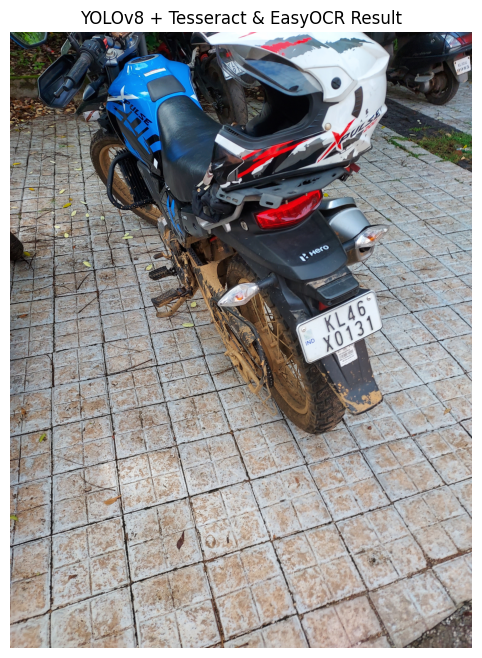

In [6]:
import cv2
import pytesseract
import easyocr
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os

# Paths
model_path = r"C:\Users\Anirudh\Downloads\yolov8_number_plate.pt"
image_path = r"C:\Users\Anirudh\Downloads\images\20230626_091625.jpg" # Use the previous image for comparison
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# Load YOLOv8 model
model = YOLO(model_path)

# Load image
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Run inference
results = model.predict(image_path, imgsz=640, conf=0.5)
boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)

# Initialize OCR readers
easyocr_reader = easyocr.Reader(['en'])

# OCR on detected license plates
for i, box in enumerate(boxes):
    x1, y1, x2, y2 = box
    plate_img = image[y1:y2, x1:x2]

    # Enhance for better OCR
    gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    _, thresholded = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # OCR with Tesseract
    tesseract_config = '--psm 8 --oem 3 tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
    tesseract_text = pytesseract.image_to_string(thresholded, config=tesseract_config).strip()
    tesseract_text = tesseract_text if tesseract_text else "Tesseract Failed"
    print(f"🔍 Plate {i+1} (Tesseract): {tesseract_text}")

    # OCR with EasyOCR
    easyocr_result = easyocr_reader.readtext(enhanced)
    easyocr_text = ' '.join([res[1] for res in easyocr_result]).strip() if easyocr_result else "EasyOCR Failed"
    print(f"🔍 Plate {i+1} (EasyOCR): {easyocr_text}")

    # Choose which text to display (you can implement more sophisticated logic)
    displayed_text = f"T:{tesseract_text} / E:{easyocr_text}"

    # Draw bounding box and combined text
    cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image_rgb, displayed_text, (x1, y1 - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2, cv2.LINE_AA)
    cv2.putText(image_rgb, "(T/E)", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1, cv2.LINE_AA)

# Show result
plt.figure(figsize=(10, 8))
plt.imshow(image_rgb)
plt.axis('off')
plt.title("YOLOv8 + Tesseract & EasyOCR Result")
plt.show()

In [5]:
import cv2
import pytesseract
import easyocr
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os

# --- Configuration ---
model_path = r"C:\Users\Anirudh\Downloads\yolov8_number_plate.pt"  # Replace with your model path
image_directory = r"C:\Users\Anirudh\Downloads\Vehicle Registration Plates.v2-licenseplatedatasetv1.yolov8\val\images"  # <--- ENSURE THIS PATH IS CORRECT
ground_truth_file = r"C:\Users\Anirudh\Downloads\Vehicle Registration Plates.v2-licenseplatedatasetv1.yolov8\val\_annotations.txt"  # File containing ground truth (if available)
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"  # Update if needed
easyocr_reader = easyocr.Reader(['en'])
confidence_threshold_yolo = 0.5
iou_threshold_yolo = 0.5
psm_config_tesseract = '--psm 8 --oem 3 tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
# ---------------------

def load_ground_truth(file_path):
    """Loads ground truth annotations from a file.
    Assumes a simple format: image_name.jpg x1 y1 x2 y2 text
    Returns a dictionary: {image_name: [{'bbox': [x1, y1, x2, y2], 'text': 'GROUNDTRUTH'}]}
    """
    ground_truth = {}
    if not os.path.exists(file_path):
        print(f"Warning: Ground truth file not found at {file_path}")
        return ground_truth
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 6:
                image_name = parts[0]
                bbox = [int(float(x)) for x in parts[1:5]]
                text = " ".join(parts[5:])
                if image_name not in ground_truth:
                    ground_truth[image_name] = []
                ground_truth[image_name].append({'bbox': bbox, 'text': text})
    return ground_truth

def calculate_iou(box1, box2):
    """Calculates the Intersection over Union (IoU) of two bounding boxes."""
    x1_1, y1_1, x2_1, y2_1 = box1
    x1_2, y1_2, x2_2, y2_2 = box2

    xi1 = max(x1_1, x1_2)
    yi1 = max(y1_1, y1_2)
    xi2 = min(x2_1, x2_2)
    yi2 = min(y2_1, y2_2)

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)

    box1_area = (x2_1 - x1_1) * (y2_1 - y1_1)
    box2_area = (x2_2 - x1_2) * (y2_2 - y1_2)

    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

def evaluate_image(image_path, model, ground_truth):
    """Evaluates the detection and recognition on a single image."""
    image_name = os.path.basename(image_path)
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    detected_plates = []

    # YOLOv8 Detection
    results = model.predict(image_path, imgsz=640, conf=confidence_threshold_yolo, iou=iou_threshold_yolo)
    boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)

    for box in boxes:
        x1, y1, x2, y2 = box
        plate_img = image[y1:y2, x1:x2]
        detected_plates.append({'bbox': [x1, y1, x2, y2], 'image': plate_img})

    # OCR
    for plate in detected_plates:
        gray = cv2.cvtColor(plate['image'], cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(gray)
        _, thresholded = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        tesseract_text = pytesseract.image_to_string(thresholded, config=psm_config_tesseract).strip()
        easyocr_result = easyocr_reader.readtext(enhanced)
        easyocr_text = ' '.join([res[1] for res in easyocr_result]).strip()

        plate['tesseract_text'] = tesseract_text
        plate['easyocr_text'] = easyocr_text

    # Evaluation against ground truth
    matches = []
    if image_name in ground_truth:
        for gt in ground_truth[image_name]:
            best_iou = 0
            best_detection = None
            for det in detected_plates:
                iou = calculate_iou(gt['bbox'], det['bbox'])
                if iou > best_iou:
                    best_iou = iou
                    best_detection = det
            if best_detection is not None and best_iou > 0.5:  # Adjust IoU threshold as needed
                matches.append({'gt': gt['text'], 'tesseract': best_detection.get('tesseract_text', ''), 'easyocr': best_detection.get('easyocr_text', '')})

    return image_rgb, detected_plates, matches

if __name__ == "__main__":
    model = YOLO(model_path)
    ground_truth_data = load_ground_truth(ground_truth_file)
    image_files = []
    if os.path.exists(image_directory):
        image_files = [os.path.join(image_directory, f) for f in os.listdir(image_directory) if f.endswith(('.jpg', '.jpeg', '.png'))]
    else:
        print(f"Error: Image directory not found at {image_directory}. Please correct the path.")

    total_images = len(image_files)
    correct_detections = 0
    correct_tesseract_recognitions = 0
    correct_easyocr_recognitions = 0
    total_ground_truth_plates = 0
    detected_ground_truth_plates = 0

    for i, image_file in enumerate(image_files):
        print(f"Processing image {i+1}/{total_images}: {os.path.basename(image_file)}")
        annotated_image, detections, matches = evaluate_image(image_file, model, ground_truth_data)

        if os.path.basename(image_file) in ground_truth_data:
            total_ground_truth_plates += len(ground_truth_data[os.path.basename(image_file)])
            if detections:
                detected_ground_truth_plates += 1 # Simple count, can be refined with IoU

        for match in matches:
            if match['gt'].lower() == match['tesseract'].lower():
                correct_tesseract_recognitions += 1
            if match['gt'].lower() == match['easyocr'].lower():
                correct_easyocr_recognitions += 1

        # Visualize results for the current image (optional)
        for det in detections:
            bbox = det['bbox']
            t_text = det.get('tesseract_text', 'T:Failed')
            e_text = det.get('easyocr_text', 'E:Failed')
            cv2.rectangle(annotated_image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
            cv2.putText(annotated_image, f"T:{t_text}", (bbox[0], bbox[1] - 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2, cv2.LINE_AA)
            cv2.putText(annotated_image, f"E:{e_text}", (bbox[0], bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2, cv2.LINE_AA)

        plt.figure(figsize=(12, 8))
        plt.imshow(annotated_image)
        plt.title(f"Image: {os.path.basename(image_file)}")
        plt.axis('off')
        plt.show()

    if total_ground_truth_plates > 0:
        detection_rate = (detected_ground_truth_plates / total_ground_truth_plates) * 100
        tesseract_accuracy = (correct_tesseract_recognitions / total_ground_truth_plates) * 100
        easyocr_accuracy = (correct_easyocr_recognitions / total_ground_truth_plates) * 100

        print("\n--- Evaluation Summary ---")
        print(f"Total Images Processed: {total_images}")
        print(f"Total Ground Truth Plates: {total_ground_truth_plates}")
        print(f"Detection Rate (at least one detection per GT): {detection_rate:.2f}%")
        print(f"Tesseract Recognition Accuracy (exact match): {tesseract_accuracy:.2f}%")
        print(f"EasyOCR Recognition Accuracy (exact match): {easyocr_accuracy:.2f}%")
    else:
        print("\n--- Evaluation Summary ---")
        print("No ground truth data found for evaluation.")

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Error: Image directory not found at C:\Users\Anirudh\Downloads\Vehicle Registration Plates.v2-licenseplatedatasetv1.yolov8\val\images. Please correct the path.

--- Evaluation Summary ---
No ground truth data found for evaluation.



image 1/1 C:\Users\Anirudh\Downloads\images\20230719_104650.jpg: 480x640 1 license_plate, 228.4ms
Speed: 7.9ms preprocess, 228.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


🔍 Plate 1: KLOZB IND S9532


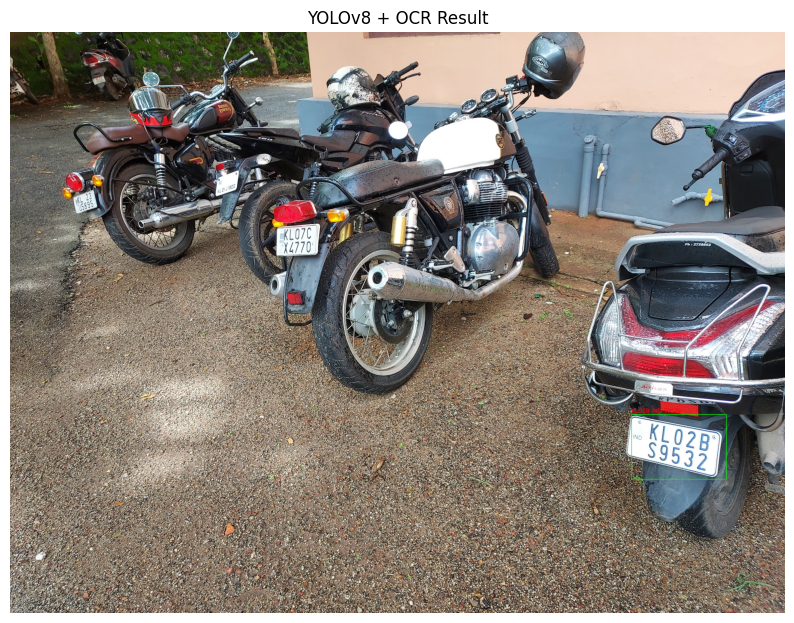

In [3]:
import cv2
import easyocr
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os

# Paths
model_path = r"C:\Users\Anirudh\Downloads\yolov8_number_plate.pt"
image_path = r"C:\Users\Anirudh\Downloads\images\20230719_104650.jpg"

# Load YOLOv8 model
model = YOLO(model_path)

# Load image
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Run inference
results = model.predict(image_path, imgsz=640, conf=0.5)
boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)

# Initialize OCR
reader = easyocr.Reader(['en'])

# OCR on detected license plates
for i, box in enumerate(boxes):
    x1, y1, x2, y2 = box
    plate_img = image[y1:y2, x1:x2]

    # Enhance for better OCR
    gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)

    # OCR
    result = reader.readtext(enhanced)
    text = ' '.join([res[1] for res in result]) if result else "OCR Failed"

    # Display
    print(f"🔍 Plate {i+1}: {text}")
    cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image_rgb, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

# Show result
plt.figure(figsize=(10, 8))
plt.imshow(image_rgb)
plt.axis('off')
plt.title("YOLOv8 + OCR Result")
plt.show()


In [6]:
!pip install torch torchvision torchaudio
!pip install opencv-python
!pip install matplotlib
!pip install git+https://github.com/clovaai/CRAFT-pytorch.git
!pip install git+https://github.com/meijieru/crnn.pytorch.git


  Cloning https://github.com/clovaai/CRAFT-pytorch.git to c:\users\anirudh\appdata\local\temp\pip-req-build-ypavd70e


  ERROR: Error [WinError 2] The system cannot find the file specified while executing command git version
ERROR: Cannot find command 'git' - do you have 'git' installed and in your PATH?


  Cloning https://github.com/meijieru/crnn.pytorch.git to c:\users\anirudh\appdata\local\temp\pip-req-build-jt8xg5p6


  ERROR: Error [WinError 2] The system cannot find the file specified while executing command git version
ERROR: Cannot find command 'git' - do you have 'git' installed and in your PATH?


In [12]:
!pip install craft-text-detector
!pip install opencv-python-headless torchvision torch matplotlib


     ---------------------------------------- 0.0/89.8 MB ? eta -:--:--
     ---------------------------------------- 0.8/89.8 MB 3.1 MB/s eta 0:00:29
      --------------------------------------- 1.8/89.8 MB 4.0 MB/s eta 0:00:22
     - -------------------------------------- 3.4/89.8 MB 5.1 MB/s eta 0:00:17
     -- ------------------------------------- 5.0/89.8 MB 5.7 MB/s eta 0:00:15
     -- ------------------------------------- 6.3/89.8 MB 6.0 MB/s eta 0:00:14
     --- ------------------------------------ 8.1/89.8 MB 6.3 MB/s eta 0:00:13
     ---- ----------------------------------- 9.7/89.8 MB 6.5 MB/s eta 0:00:13
     ---- ----------------------------------- 11.0/89.8 MB 6.4 MB/s eta 0:00:13
     ----- ---------------------------------- 12.6/89.8 MB 6.5 MB/s eta 0:00:12
     ------ --------------------------------- 13.9/89.8 MB 6.5 MB/s eta 0:00:12
     ------ --------------------------------- 15.5/89.8 MB 6.5 MB/s eta 0:00:12
     ------- -------------------------------- 16.8/89.8

  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      Ignoring numpy: markers 'python_version == "3.6" and platform_machine != "aarch64" and platform_machine != "arm64"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.7" and platform_machine != "aarch64" and platform_machine != "arm64"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.8" and platform_machine != "aarch64" and platform_machine != "arm64"' don't match your environment
      Ignoring numpy: markers 'python_version <= "3.9" and sys_platform == "linux" and platform_machine == "aarch64"' don't match your environment
      Ignoring numpy: markers 'python_version <= "3.9" and sys_platform == "darwin" and platform_machine == "arm64"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.9" and platform_machine != "aarch64" and p

In [3]:
!git clone https://github.com/clovaai/CRAFT-pytorch.git
%cd CRAFT-pytorch
!pip install -r requirements.txt


[WinError 2] The system cannot find the file specified: 'CRAFT-pytorch'
c:\Users\Anirudh\Downloads


'git' is not recognized as an internal or external command,
operable program or batch file.
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'



image 1/1 C:\Users\Anirudh\Downloads\images\20230620_161145ll.jpg: 640x480 1 license_plate, 101.0ms
Speed: 6.1ms preprocess, 101.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


🔍 Plate 1: IND TN75aP6563


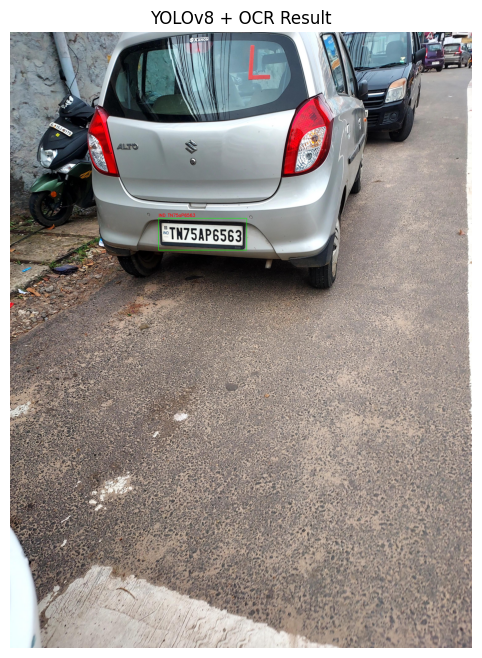

In [6]:
import cv2
import easyocr
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os

# Paths
model_path = r"C:\Users\Anirudh\Downloads\yolov8_number_plate.pt"
image_path = r"C:\Users\Anirudh\Downloads\images\20230620_161145ll.jpg"

# Load YOLOv8 model
model = YOLO(model_path)

# Load image
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Run inference
results = model.predict(image_path, imgsz=640, conf=0.5)
boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)

# Initialize OCR
reader = easyocr.Reader(['en'])

# OCR on detected license plates
for i, box in enumerate(boxes):
    x1, y1, x2, y2 = box
    plate_img = image[y1:y2, x1:x2]

    # Enhance for better OCR
    gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)

    # OCR
    result = reader.readtext(enhanced)
    text = ' '.join([res[1] for res in result]) if result else "OCR Failed"

    # Display
    print(f"🔍 Plate {i+1}: {text}")
    cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image_rgb, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

# Show result
plt.figure(figsize=(10, 8))
plt.imshow(image_rgb)
plt.axis('off')
plt.title("YOLOv8 + OCR Result")
plt.show()






image 1/1 C:\Users\Anirudh\Downloads\images\20230626_091621.jpg: 640x480 1 license_plate, 188.5ms
Speed: 5.1ms preprocess, 188.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


🔍 Plate 1: KL.01 M.6422


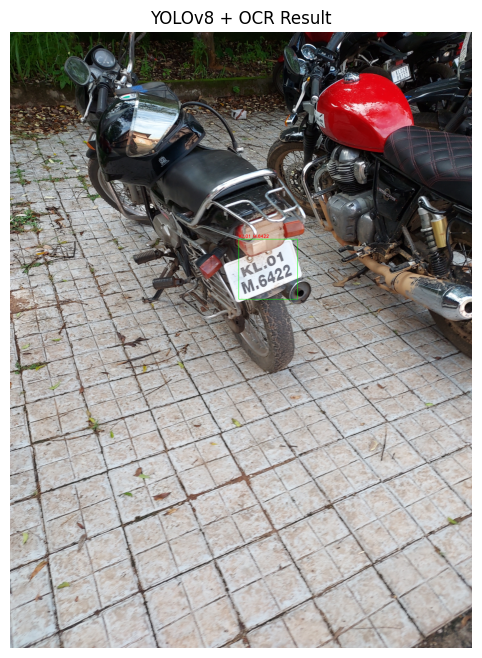

In [8]:
import cv2
import easyocr
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os

# Paths
model_path = r"C:\Users\Anirudh\Downloads\yolov8_number_plate.pt"
image_path = r"C:\Users\Anirudh\Downloads\images\20230626_091621.jpg"

# Load YOLOv8 model
model = YOLO(model_path)

# Load image
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Run inference
results = model.predict(image_path, imgsz=640, conf=0.5)
boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)

# Initialize OCR
reader = easyocr.Reader(['en'])

# OCR on detected license plates
for i, box in enumerate(boxes):
    x1, y1, x2, y2 = box
    plate_img = image[y1:y2, x1:x2]

    # Enhance for better OCR
    gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)

    # OCR
    result = reader.readtext(enhanced)
    text = ' '.join([res[1] for res in result]) if result else "OCR Failed"

    # Display
    print(f"🔍 Plate {i+1}: {text}")
    cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image_rgb, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

# Show result
plt.figure(figsize=(10, 8))
plt.imshow(image_rgb)
plt.axis('off')
plt.title("YOLOv8 + OCR Result")
plt.show()





In [8]:
import cv2
import torch
import matplotlib.pyplot as plt
from ultralytics import YOLO
from craft_text_detector import Craft
from crnn_model import CRNNModel  # You'll need to define CRNNModel or load from repo
import os

# === Paths ===
model_path = r"C:\Users\Anirudh\Downloads\yolov8_number_plate.pt"
image_path = r"C:\Users\Anirudh\Downloads\Vehicle Registration Plates.v2-licenseplatedatasetv1.yolov8\train\images\02f914b2cec48820_jpg.rf.59e76f77be2bcdd0d1c7a6bba5224a00.jpg"
craft_weights_path = r"C:\Users\Anirudh\Downloads\ocr_weights\craft_mlt_25k.pth"
crnn_weights_path = r"C:\Users\Anirudh\Downloads\ocr_weights\crnn.pth"

# === Load YOLOv8 ===
yolo_model = YOLO(model_path)

# === Load image ===
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# === Inference ===
results = yolo_model.predict(image_path, imgsz=640, conf=0.5)
boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)

# === Load CRAFT for OCR ===
craft = Craft(output_dir=None, crop_type="poly", cuda=torch.cuda.is_available(), weight_path=craft_weights_path)

# === Load CRNN model ===
# Assume you have a function to load CRNN; use pretrained weights from Meijieru’s repo
crnn = CRNNModel()
crnn.load_state_dict(torch.load(crnn_weights_path, map_location="cpu"))
crnn.eval()

# === OCR from cropped plates ===
for i, box in enumerate(boxes):
    x1, y1, x2, y2 = box
    plate_crop = image_rgb[y1:y2, x1:x2]

    # Step 1: Use CRAFT to detect text areas
    prediction_result = craft.detect_text(plate_crop)
    text_regions = prediction_result["boxes"]

    # Step 2: Use CRNN to recognize text in each region
    plate_text = ""
    for region in text_regions:
        x_min, y_min = map(int, region[0])
        x_max, y_max = map(int, region[2])
        char_crop = plate_crop[y_min:y_max, x_min:x_max]
        char_gray = cv2.cvtColor(char_crop, cv2.COLOR_RGB2GRAY)
        char_resized = cv2.resize(char_gray, (100, 32))
        char_tensor = torch.tensor(char_resized / 255.0).unsqueeze(0).unsqueeze(0).float()
        
        with torch.no_grad():
            output = crnn(char_tensor)
            _, preds = output.max(2)
            text = "".join([str(p.item()) for p in preds[0]])
            plate_text += text

    # === Draw results ===
    cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image_rgb, plate_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
    print(f"🔍 Plate {i+1}: {plate_text}")

# === Show image ===
plt.figure(figsize=(10, 8))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("YOLOv8 + CRAFT + CRNN OCR Result")
plt.show()

# Cleanup CRAFT
craft.unload_craftnet_model()
craft.unload_refinenet_model()


ModuleNotFoundError: No module named 'craft_text_detector'

In [3]:
!pip install torch torchvision
!pip install --upgrade pip
!pip install torch==2.1.0
!pip install torchvision==0.15.0




ERROR: Could not find a version that satisfies the requirement torch==2.1.0 (from versions: 2.6.0)
ERROR: No matching distribution found for torch==2.1.0
ERROR: Ignored the following yanked versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3
ERROR: Could not find a version that satisfies the requirement torchvision==0.15.0 (from versions: 0.21.0)
ERROR: No matching distribution found for torchvision==0.15.0


In [8]:
!pip install torch
!pip install torchvision


In [11]:
!pip install torch==1.10.0+cpu torchvision==0.11.0+cpu --no-deps


ERROR: Could not find a version that satisfies the requirement torch==1.10.0+cpu (from versions: 2.6.0)
ERROR: No matching distribution found for torch==1.10.0+cpu


In [14]:
!pip install pytesseract





image 1/1 C:\Users\Anirudh\Downloads\images\20230719_104650.jpg: 480x640 1 license_plate, 294.0ms
Speed: 5.6ms preprocess, 294.0ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)
🔍 Plate 1: gy


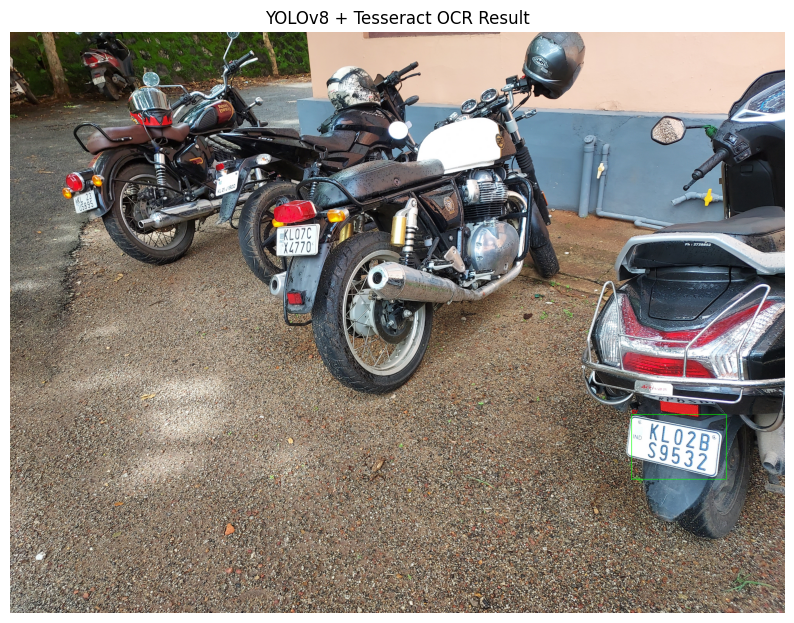

In [2]:
import cv2
import pytesseract
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os

# Paths
model_path = r"C:\Users\Anirudh\Downloads\yolov8_number_plate.pt"
image_path = r"C:\Users\Anirudh\Downloads\images\20230719_104650.jpg"

# Tesseract executable path (Update this if needed)
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# Load YOLOv8 model
model = YOLO(model_path)

# Load image
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Run inference
results = model.predict(image_path, imgsz=640, conf=0.5)
boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)

# OCR using pytesseract on detected license plates
for i, box in enumerate(boxes):
    x1, y1, x2, y2 = box
    plate_img = image[y1:y2, x1:x2]

    # Enhance for better OCR
    gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)

    # OCR using pytesseract
    text = pytesseract.image_to_string(enhanced, config='--psm 8')  # PSM 8 is for sparse text

    # Clean and display OCR result
    text = text.strip() if text.strip() else "OCR Failed"
    print(f"🔍 Plate {i+1}: {text}")

    # Draw bounding box and text
    cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image_rgb, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

# Show result
plt.figure(figsize=(10, 8))
plt.imshow(image_rgb)
plt.axis('off')
plt.title("YOLOv8 + Tesseract OCR Result")
plt.show()



image 1/1 C:\Users\Anirudh\Downloads\images\20230620_161145ll.jpg: 640x480 1 license_plate, 227.6ms
Speed: 4.7ms preprocess, 227.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)
🔍 Plate 1: ETW75aP6se3}


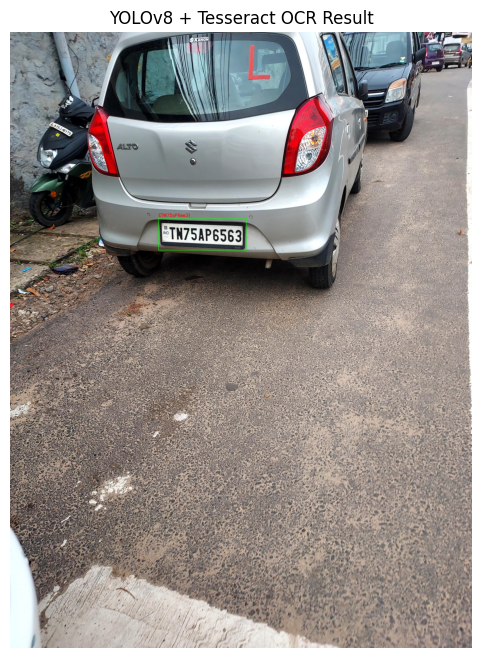

In [5]:
import cv2
import pytesseract
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os

# Paths
model_path = r"C:\Users\Anirudh\Downloads\yolov8_number_plate.pt"
image_path = r"C:\Users\Anirudh\Downloads\images\20230620_161145ll.jpg"

# Tesseract executable path (Update this if needed)
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# Load YOLOv8 model
model = YOLO(model_path)

# Load image
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Run inference
results = model.predict(image_path, imgsz=640, conf=0.5)
boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)

# OCR using pytesseract on detected license plates
for i, box in enumerate(boxes):
    x1, y1, x2, y2 = box
    plate_img = image[y1:y2, x1:x2]

    # Enhance for better OCR
    gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)

    # OCR using pytesseract
    text = pytesseract.image_to_string(enhanced, config='--psm 8')  # PSM 8 is for sparse text

    # Clean and display OCR result
    text = text.strip() if text.strip() else "OCR Failed"
    print(f"🔍 Plate {i+1}: {text}")

    # Draw bounding box and text
    cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image_rgb, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

# Show result
plt.figure(figsize=(10, 8))
plt.imshow(image_rgb)
plt.axis('off')
plt.title("YOLOv8 + Tesseract OCR Result")
plt.show()



image 1/1 C:\Users\Anirudh\Downloads\images\20230719_104650.jpg: 480x640 1 license_plate, 156.0ms
Speed: 5.2ms preprocess, 156.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)
🔍 Plate 1: 238]


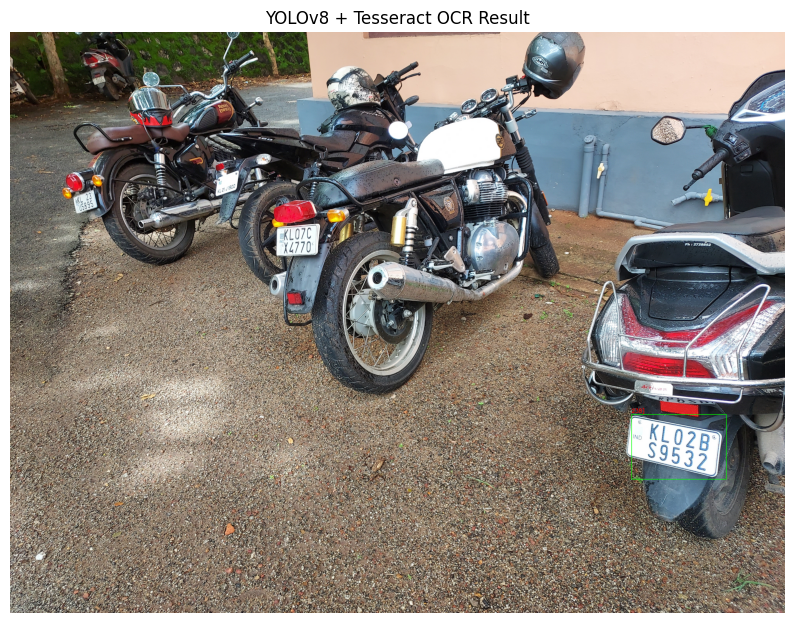

In [4]:
import cv2
import pytesseract
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os

# Paths
model_path = r"C:\Users\Anirudh\Downloads\yolov8_number_plate.pt"
image_path = r"C:\Users\Anirudh\Downloads\images\20230719_104650.jpg"

# Tesseract executable path (Update this if needed)
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# Load YOLOv8 model
model = YOLO(model_path)

# Load image
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Run inference
results = model.predict(image_path, imgsz=640, conf=0.5)
boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)

# OCR using pytesseract on detected license plates
for i, box in enumerate(boxes):
    x1, y1, x2, y2 = box
    plate_img = image[y1:y2, x1:x2]

    # Enhance for better OCR
    gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)

    # Further enhancement: Thresholding
    _, thresholded = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # OCR using pytesseract with different PSM and whitelist
    config_sparse = '--psm 8'
    config_single_line = '--psm 7'
    whitelist = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'

    text_sparse = pytesseract.image_to_string(thresholded, config=config_sparse)
    text_single = pytesseract.image_to_string(thresholded, config=config_single_line, nice=whitelist)

    text = ""
    if len(text_single.strip()) > len(text_sparse.strip()):
        text = text_single.strip()
    else:
        text = text_sparse.strip()

    # Clean and display OCR result
    text = text.strip() if text.strip() else "OCR Failed"
    print(f"🔍 Plate {i+1}: {text}")

    # Draw bounding box and text
    cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image_rgb, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

# Show result
plt.figure(figsize=(10, 8))
plt.imshow(image_rgb)
plt.axis('off')
plt.title("YOLOv8 + Tesseract OCR Result")
plt.show()

In [ ]:
import os
import cv2
import torch
import yaml
import easyocr
import numpy as np
import matplotlib.pyplot as plt
import pytesseract  # Import Tesseract

from ultralytics import YOLO

# --- Configuration ---
MODEL_PATH = r"C:\Users\Anirudh\Downloads\yolov8_number_plate.pt"
TEST_IMAGE_PATH = r"C:\Users\Anirudh\Downloads\Vehicle Registration Plates.v2-licenseplatedatasetv1.yolov8\test\images\xemayBigPlate40_jpg.rf.6df5c04e4b8f656ec0670651b09c4cf8.jpg"

# Initialize YOLOv8 model
try:
    model = YOLO(MODEL_PATH)
    print(f"✅ YOLOv8 model loaded from: {MODEL_PATH}")
except FileNotFoundError:
    print(f"❌ Error: YOLOv8 model not found at: {MODEL_PATH}")
    exit()

# Initialize EasyOCR with number and letter allowlist
try:
    reader_easyocr = easyocr.Reader(['en'], allowlist='ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789- ')
    print("✅ EasyOCR reader initialized with allowlist.")
except Exception as e:
    print(f"❌ Error initializing EasyOCR: {e}")
    exit()

# Configure Tesseract (update path if needed)
try:
    pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
    tesseract_available = True
    print("✅ Tesseract OCR is available.")
except pytesseract.TesseractNotFoundError:
    tesseract_available = False
    print("⚠️ Tesseract is not installed or configured correctly.")

def enhance_plate_image(plate_img):
    gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    # Experiment with additional enhancements if needed
    # _, enhanced = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return enhanced

def detect_and_recognize_plate(image_path, confidence_threshold=0.01):
    try:
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    except Exception as e:
        print(f"❌ Error loading image at {image_path}: {e}")
        return None, []

    detected_plates_info = []

    # Run YOLOv8 inference
    results = model.predict(image_path, imgsz=640, conf=confidence_threshold)
    boxes = results[0].boxes

    if boxes is not None and len(boxes.conf) > 0:
        print("\n--- Detected Boxes (with Confidence) ---")
        for i, conf in enumerate(boxes.conf):
            xyxy = boxes.xyxy.cpu().numpy().astype(int)[i]
            print(f"Box {i}: {xyxy}, Confidence: {conf:.4f}")
            if conf >= confidence_threshold:
                x1, y1, x2, y2 = xyxy
                plate_img_cropped = image[y1:y2, x1:x2]
                enhanced_plate_img = enhance_plate_image(plate_img_cropped)

                easyocr_text = ""
                easyocr_result = reader_easyocr.readtext(enhanced_plate_img)
                if easyocr_result:
                    easyocr_text = ' '.join([res[1] for res in easyocr_result]).strip()

                tesseract_text = ""
                if tesseract_available:
                    tesseract_config_numbers = '--psm 8 --oem 3 tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ-'
                    tesseract_text = pytesseract.image_to_string(enhanced_plate_img, config=tesseract_config_numbers).strip()

                final_text = easyocr_text  # Default to EasyOCR

                if tesseract_text and len(tesseract_text) > len(easyocr_text) and any(char.isdigit() for char in tesseract_text):
                    final_text = tesseract_text
                elif tesseract_text and not easyocr_text and any(char.isdigit() for char in tesseract_text):
                    final_text = tesseract_text

                detected_plates_info.append({'bbox': [x1, y1, x2, y2], 'text': final_text, 'confidence': conf.item()})
                cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(image_rgb, f"{final_text} ({conf:.2f})", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
        else:
            print("\nNo boxes detected with the current confidence threshold.")

    return image_rgb, detected_plates_info

if __name__ == "__main__":
    test_image_path = r"C:\Users\Anirudh\Downloads\Vehicle Registration Plates.v2-licenseplatedatasetv1.yolov8\test\images\xemayBigPlate40_jpg.rf.6df5c04e4b8f656ec0670651b09c4cf8.jpg"

    processed_image, detected_plates = detect_and_recognize_plate(test_image_path, confidence_threshold=0.01)

    if processed_image is not None:
        plt.figure(figsize=(10, 8))
        plt.imshow(processed_image)
        plt.axis('off')
        plt.title("YOLOv8 Detection and OCR Result (EasyOCR & Tesseract)")
        plt.show()

        if detected_plates:
            print("\n--- Detected License Plates ---")
            for plate_info in detected_plates:
                print(f"Bounding Box: {plate_info['bbox']}, Confidence: {plate_info['confidence']:.4f}, Recognized Text: {plate_info['text']}")
        else:
            print("\nNo license plates detected in the image (even with very low confidence).")

        # Also print the raw results for inspection
        model = YOLO(MODEL_PATH) # Reload model for predict call
        results = model.predict(test_image_path, imgsz=640, conf=0.5)
        print("\n--- Raw YOLOv8 Results ---")
        print(results)

✅ YOLOv8 model loaded from: C:\Users\Anirudh\Downloads\yolov8_number_plate.pt
❌ Error initializing EasyOCR: Reader.__init__() got an unexpected keyword argument 'allowlist'
✅ Tesseract OCR is available.

image 1/1 C:\Users\Anirudh\Downloads\Vehicle Registration Plates.v2-licenseplatedatasetv1.yolov8\test\images\xemayBigPlate40_jpg.rf.6df5c04e4b8f656ec0670651b09c4cf8.jpg: 640x640 2 license_plates, 248.7ms
Speed: 21.0ms preprocess, 248.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

--- Detected Boxes (with Confidence) ---
Box 0: [103 176 220 292], Confidence: 0.5706


NameError: name 'reader_easyocr' is not defined

: 

In [ ]:
import os
import cv2
import torch
import yaml
import easyocr
import numpy as np
import matplotlib.pyplot as plt
import pytesseract

from ultralytics import YOLO

# --- Configuration ---
MODEL_PATH = r"C:\Users\Anirudh\Downloads\yolov8_number_plate.pt"
TEST_IMAGE_PATH = r"C:\Users\Anirudh\Downloads\Vehicle Registration Plates.v2-licenseplatedatasetv1.yolov8\test\images\xemayBigPlate40_jpg.rf.6df5c04e4b8f656ec0670651b09c4cf8.jpg"

# Initialize YOLOv8 model
try:
    model = YOLO(MODEL_PATH)
    print(f"✅ YOLOv8 model loaded from: {MODEL_PATH}")
except FileNotFoundError:
    print(f"❌ Error: YOLOv8 model not found at: {MODEL_PATH}")
    exit()

# Initialize EasyOCR with number and letter allowlist
try:
    reader_easyocr = easyocr.Reader(['en'], allowlist='ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789- ')
    print("✅ EasyOCR reader initialized with allowlist.")
except Exception as e:
    print(f"❌ Error initializing EasyOCR: {e}")
    exit()

# Configure Tesseract (update path if needed)
try:
    pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
    tesseract_available = True
    print("✅ Tesseract OCR is available.")
except pytesseract.TesseractNotFoundError:
    tesseract_available = False
    print("⚠️ Tesseract is not installed or configured correctly.")

def enhance_plate_image(plate_img):
    gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    return enhanced

def detect_and_recognize_plate(image_path, confidence_threshold, easyocr_reader): # Accept easyocr_reader
    try:
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    except Exception as e:
        print(f"❌ Error loading image at {image_path}: {e}")
        return None, []

    detected_plates_info = []

    results = model.predict(image_path, imgsz=640, conf=confidence_threshold)
    boxes = results[0].boxes

    if boxes is not None and len(boxes.conf) > 0:
        print("\n--- Detected Boxes (with Confidence) ---")
        for i, conf in enumerate(boxes.conf):
            xyxy = boxes.xyxy.cpu().numpy().astype(int)[i]
            print(f"Box {i}: {xyxy}, Confidence: {conf:.4f}")
            if conf >= confidence_threshold:
                x1, y1, x2, y2 = xyxy
                plate_img_cropped = image[y1:y2, x1:x2]
                enhanced_plate_img = enhance_plate_image(plate_img_cropped)

                easyocr_text = ""
                easyocr_result = easyocr_reader.readtext(enhanced_plate_img) # Use the passed argument
                if easyocr_result:
                    easyocr_text = ' '.join([res[1] for res in easyocr_result]).strip()

                tesseract_text = ""
                if tesseract_available:
                    tesseract_config_numbers = '--psm 8 --oem 3 tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ-'
                    tesseract_text = pytesseract.image_to_string(enhanced_plate_img, config=tesseract_config_numbers).strip()

                final_text = easyocr_text

                if tesseract_text and len(tesseract_text) > len(easyocr_text) and any(char.isdigit() for char in tesseract_text):
                    final_text = tesseract_text
                elif tesseract_text and not easyocr_text and any(char.isdigit() for char in tesseract_text):
                    final_text = tesseract_text

                detected_plates_info.append({'bbox': [x1, y1, x2, y2], 'text': final_text, 'confidence': conf.item()})
                cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(image_rgb, f"{final_text} ({conf:.2f})", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
        else:
            print("\nNo boxes detected with the current confidence threshold.")

    return image_rgb, detected_plates_info

if __name__ == "__main__":
    test_image_path = r"C:\Users\Anirudh\Downloads\Vehicle Registration Plates.v2-licenseplatedatasetv1.yolov8\test\images\xemayBigPlate40_jpg.rf.6df5c04e4b8f656ec0670651b09c4cf8.jpg"

    processed_image, detected_plates = detect_and_recognize_plate(test_image_path, confidence_threshold=0.01, easyocr_reader=reader_easyocr) # Pass the reader

    if processed_image is not None:
        plt.figure(figsize=(10, 8))
        plt.imshow(processed_image)
        plt.axis('off')
        plt.title("YOLOv8 Detection and OCR Result (EasyOCR & Tesseract)")
        plt.show()

        if detected_plates:
            print("\n--- Detected License Plates ---")
            for plate_info in detected_plates:
                print(f"Bounding Box: {plate_info['bbox']}, Confidence: {plate_info['confidence']:.4f}, Recognized Text: {plate_info['text']}")
        else:
            print("\nNo license plates detected in the image (even with very low confidence).")

        model = YOLO(MODEL_PATH)
        results = model.predict(test_image_path, imgsz=640, conf=0.5)
        print("\n--- Raw YOLOv8 Results ---")
        print(results)

✅ YOLOv8 model loaded from: C:\Users\Anirudh\Downloads\yolov8_number_plate.pt
❌ Error initializing EasyOCR: Reader.__init__() got an unexpected keyword argument 'allowlist'
✅ Tesseract OCR is available.


NameError: name 'reader_easyocr' is not defined

: 

In [1]:
import sys
print(sys.executable)

c:\Users\Anirudh\AppData\Local\Programs\Python\Python313\python.exe


In [ ]:
import os
import cv2
import torch
import yaml
import easyocr
import numpy as np
import matplotlib.pyplot as plt
import pytesseract

from ultralytics import YOLO

# --- Configuration ---
MODEL_PATH = r"C:\Users\Anirudh\Downloads\yolov8_number_plate.pt"
TEST_IMAGE_PATH = r"C:\Users\Anirudh\Downloads\Vehicle Registration Plates.v2-licenseplatedatasetv1.yolov8\test\images\xemayBigPlate40_jpg.rf.6df5c04e4b8f656ec0670651b09c4cf8.jpg"

# Initialize YOLOv8 model
try:
    model = YOLO(MODEL_PATH)
    print(f"✅ YOLOv8 model loaded from: {MODEL_PATH}")
except FileNotFoundError:
    print(f"❌ Error: YOLOv8 model not found at: {MODEL_PATH}")
    exit()

# Initialize EasyOCR with number and letter allowlist
try:
    languages = ['en']
    allow_list_chars = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789- '
    reader_easyocr = easyocr.Reader(languages, allowlist=allow_list_chars)
    print("✅ EasyOCR reader initialized with allowlist.")
except Exception as e:
    print(f"❌ Error initializing EasyOCR: {e}")
    exit()

# Configure Tesseract (update path if needed)
try:
    pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
    tesseract_available = True
    print("✅ Tesseract OCR is available.")
except pytesseract.TesseractNotFoundError:
    tesseract_available = False
    print("⚠️ Tesseract is not installed or configured correctly.")

def enhance_plate_image(plate_img):
    gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    return enhanced

def detect_and_recognize_plate(image_path, confidence_threshold, easyocr_reader):
    try:
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    except Exception as e:
        print(f"❌ Error loading image at {image_path}: {e}")
        return None, []

    detected_plates_info = []

    results = model.predict(image_path, imgsz=640, conf=confidence_threshold)
    boxes = results[0].boxes

    if boxes is not None and len(boxes.conf) > 0:
        print("\n--- Detected Boxes (with Confidence) ---")
        for i, conf in enumerate(boxes.conf):
            xyxy = boxes.xyxy.cpu().numpy().astype(int)[i]
            print(f"Box {i}: {xyxy}, Confidence: {conf:.4f}")
            if conf >= confidence_threshold:
                x1, y1, x2, y2 = xyxy
                plate_img_cropped = image[y1:y2, x1:x2]
                enhanced_plate_img = enhance_plate_image(plate_img_cropped)

                easyocr_text = ""
                easyocr_result = easyocr_reader.readtext(enhanced_plate_img)
                if easyocr_result:
                    easyocr_text = ' '.join([res[1] for res in easyocr_result]).strip()

                tesseract_text = ""
                if tesseract_available:
                    tesseract_config_numbers = '--psm 8 --oem 3 tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ-'
                    tesseract_text = pytesseract.image_to_string(enhanced_plate_img, config=tesseract_config_numbers).strip()

                final_text = easyocr_text

                if tesseract_text and len(tesseract_text) > len(easyocr_text) and any(char.isdigit() for char in tesseract_text):
                    final_text = tesseract_text
                elif tesseract_text and not easyocr_text and any(char.isdigit() for char in tesseract_text):
                    final_text = tesseract_text

                detected_plates_info.append({'bbox': [x1, y1, x2, y2], 'text': final_text, 'confidence': conf.item()})
                cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(image_rgb, f"{final_text} ({conf:.2f})", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
        else:
            print("\nNo boxes detected with the current confidence threshold.")

    return image_rgb, detected_plates_info

if __name__ == "__main__":
    test_image_path = r"C:\Users\Anirudh\Downloads\Vehicle Registration Plates.v2-licenseplatedatasetv1.yolov8\test\images\xemayBigPlate40_jpg.rf.6df5c04e4b8f656ec0670651b09c4cf8.jpg"

    processed_image, detected_plates = detect_and_recognize_plate(test_image_path, confidence_threshold=0.01, easyocr_reader=reader_easyocr)

    if processed_image is not None:
        plt.figure(figsize=(10, 8))
        plt.imshow(processed_image)
        plt.axis('off')
        plt.title("YOLOv8 Detection and OCR Result (EasyOCR & Tesseract)")
        plt.show()

        if detected_plates:
            print("\n--- Detected License Plates ---")
            for plate_info in detected_plates:
                print(f"Bounding Box: {plate_info['bbox']}, Confidence: {plate_info['confidence']:.4f}, Recognized Text: {plate_info['text']}")
        else:
            print("\nNo license plates detected in the image (even with very low confidence).")

        model = YOLO(MODEL_PATH)
        results = model.predict(test_image_path, imgsz=640, conf=0.5)
        print("\n--- Raw YOLOv8 Results ---")
        print(results)

✅ YOLOv8 model loaded from: C:\Users\Anirudh\Downloads\yolov8_number_plate.pt
❌ Error initializing EasyOCR: Reader.__init__() got an unexpected keyword argument 'allowlist'
✅ Tesseract OCR is available.


NameError: name 'reader_easyocr' is not defined

: 

In [2]:
import easyocr

ModuleNotFoundError: No module named 'easyocr'

In [10]:
!pip install PyQt5


   ---------------------------------------- 0.0/6.9 MB ? eta -:--:--
   - -------------------------------------- 0.3/6.9 MB ? eta -:--:--
   ---- ----------------------------------- 0.8/6.9 MB 2.6 MB/s eta 0:00:03
   --------- ------------------------------ 1.6/6.9 MB 3.0 MB/s eta 0:00:02
   ------------ --------------------------- 2.1/6.9 MB 2.8 MB/s eta 0:00:02
   --------------- ------------------------ 2.6/6.9 MB 2.8 MB/s eta 0:00:02
   ------------------- -------------------- 3.4/6.9 MB 2.9 MB/s eta 0:00:02
   ---------------------- ----------------- 3.9/6.9 MB 2.8 MB/s eta 0:00:02
   --------------------------- ------------ 4.7/6.9 MB 3.0 MB/s eta 0:00:01
   ----------------------------- ---------- 5.0/6.9 MB 2.9 MB/s eta 0:00:01
   -------------------------------- ------- 5.5/6.9 MB 2.8 MB/s eta 0:00:01
   ----------------------------------- ---- 6.0/6.9 MB 2.7 MB/s eta 0:00:01
   -------------------------------------- - 6.6/6.9 MB 2.7 MB/s eta 0:00:01
   -----------------------

In [1]:
pip install --upgrade PyQt5

Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import sys
import cv2
import numpy as np
import pytesseract
import traceback
from PyQt5.QtWidgets import (QApplication, QMainWindow, QPushButton, QVBoxLayout, QHBoxLayout, 
                             QLabel, QFileDialog, QWidget, QMessageBox, QProgressBar, QTextEdit)
from PyQt5.QtGui import QPixmap, QImage
from PyQt5.QtCore import Qt, QThread, pyqtSignal, QTimer

# Set the path to the Tesseract executable
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

DEBUG = True

def log(message):
    if DEBUG:
        print(f"[DEBUG] {message}")

class PlateDetectionWorker(QThread):
    finished = pyqtSignal(list, np.ndarray)
    progress = pyqtSignal(int)
    error = pyqtSignal(str)

    def __init__(self, image):
        super().__init__()
        self.image = image

    def run(self):
        try:
            log("Starting plate detection")
            self.progress.emit(10)

            img = self.image.copy()
            result_image = img.copy()

            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            self.progress.emit(20)
            blurred = cv2.GaussianBlur(gray, (5, 5), 0)
            bilateral = cv2.bilateralFilter(blurred, 11, 17, 17)
            edges = cv2.Canny(bilateral, 30, 200)
            self.progress.emit(40)

            contours, _ = cv2.findContours(edges.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            contours = sorted(contours, key=cv2.contourArea, reverse=True)[:30]

            potential_plates = []
            self.progress.emit(60)

            for contour in contours:
                peri = cv2.arcLength(contour, True)
                approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
                if len(approx) == 4:
                    x, y, w, h = cv2.boundingRect(contour)
                    aspect_ratio = float(w) / h
                    if 1.8 < aspect_ratio < 5.5 and w * h > 1000:
                        plate_roi = img[y:y+h, x:x+w]
                        roi_gray = cv2.cvtColor(plate_roi, cv2.COLOR_BGR2GRAY)
                        roi_gray = cv2.resize(roi_gray, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
                        roi_gray = cv2.bilateralFilter(roi_gray, 11, 17, 17)
                        roi_gray = cv2.GaussianBlur(roi_gray, (3, 3), 0)
                        roi_thresh = cv2.adaptiveThreshold(
                            roi_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                            cv2.THRESH_BINARY, 11, 2)

                        custom_config = r'--oem 3 --psm 7 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
                        text = pytesseract.image_to_string(roi_thresh, config=custom_config)
                        text = text.strip()

                        if len(text) >= 4:
                            plate_info = {
                                'contour': contour,
                                'roi': plate_roi,
                                'x': x, 'y': y, 'w': w, 'h': h,
                                'plate_id': len(potential_plates) + 1,
                                'text': text
                            }
                            potential_plates.append(plate_info)

            self.progress.emit(80)

            for plate in potential_plates:
                x, y, w, h = plate['x'], plate['y'], plate['w'], plate['h']
                cv2.rectangle(result_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
                label = f"#{plate['plate_id']} {plate['text']}"
                cv2.putText(result_image, label, (x, y - 10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

            self.progress.emit(100)
            self.finished.emit(potential_plates, result_image)

        except Exception as e:
            log(traceback.format_exc())
            self.error.emit(f"Detection failed: {str(e)}")

class LicensePlateDetectorUI(QMainWindow):
    def __init__(self):
        super().__init__()
        self.setWindowTitle("License Plate Detector with OCR")
        self.setGeometry(100, 100, 1000, 700)
        self.init_ui()

    def init_ui(self):
        main_widget = QWidget()
        main_layout = QVBoxLayout()
        main_widget.setLayout(main_layout)
        self.setCentralWidget(main_widget)

        self.status_label = QLabel("Status: Ready")
        main_layout.addWidget(self.status_label)

        self.image_label = QLabel("No image loaded")
        self.image_label.setAlignment(Qt.AlignCenter)
        self.image_label.setMinimumSize(800, 500)
        main_layout.addWidget(self.image_label)

        self.results_text = QTextEdit()
        self.results_text.setReadOnly(True)
        main_layout.addWidget(self.results_text)

        self.progress_bar = QProgressBar()
        main_layout.addWidget(self.progress_bar)

        button_layout = QHBoxLayout()

        self.load_btn = QPushButton("Load Image")
        self.load_btn.clicked.connect(self.load_image)
        button_layout.addWidget(self.load_btn)

        self.process_btn = QPushButton("Detect Plates")
        self.process_btn.clicked.connect(self.detect_plates)
        self.process_btn.setEnabled(False)
        button_layout.addWidget(self.process_btn)

        self.save_btn = QPushButton("Save Result")
        self.save_btn.clicked.connect(self.save_result)
        self.save_btn.setEnabled(False)
        button_layout.addWidget(self.save_btn)

        self.reset_btn = QPushButton("Reset")
        self.reset_btn.clicked.connect(self.reset_ui)
        button_layout.addWidget(self.reset_btn)

        self.exit_btn = QPushButton("Exit")
        self.exit_btn.clicked.connect(self.close)
        button_layout.addWidget(self.exit_btn)

        main_layout.addLayout(button_layout)

        self.current_image = None
        self.result_image = None
        self.detected_plates = []

        self.timer = QTimer()
        self.timer.timeout.connect(QApplication.processEvents)
        self.timer.start(100)

    def load_image(self):
        path, _ = QFileDialog.getOpenFileName(self, "Open Image", "", "Images (*.png *.jpg *.jpeg)")
        if path:
            image = cv2.imread(path)
            if image is not None:
                self.current_image = image
                rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                h, w, _ = rgb.shape
                qimage = QImage(rgb.data, w, h, w * 3, QImage.Format_RGB888)
                self.image_label.setPixmap(QPixmap.fromImage(qimage).scaled(
                    self.image_label.size(), Qt.KeepAspectRatio, Qt.SmoothTransformation))
                self.status_label.setText("Status: Image Loaded")
                self.process_btn.setEnabled(True)
                self.results_text.clear()

    def detect_plates(self):
        if self.current_image is not None:
            self.worker = PlateDetectionWorker(self.current_image)
            self.worker.progress.connect(self.progress_bar.setValue)
            self.worker.finished.connect(self.on_detection_finished)
            self.worker.error.connect(self.show_error)
            self.worker.start()
            self.status_label.setText("Status: Processing...")

    def on_detection_finished(self, plates, result_image):
        self.detected_plates = plates
        self.result_image = result_image
        self.status_label.setText(f"Status: Detected {len(plates)} license plate(s)")

        results = ""
        for plate in plates:
            results += f"Plate #{plate['plate_id']}: Text: {plate['text']} | Size: {plate['w']}x{plate['h']} | Pos: ({plate['x']}, {plate['y']})\n"
        self.results_text.setText(results)

        rgb = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
        h, w, _ = rgb.shape
        qimage = QImage(rgb.data, w, h, w * 3, QImage.Format_RGB888)
        self.image_label.setPixmap(QPixmap.fromImage(qimage).scaled(
            self.image_label.size(), Qt.KeepAspectRatio, Qt.SmoothTransformation))

        self.save_btn.setEnabled(True)

    def save_result(self):
        path, _ = QFileDialog.getSaveFileName(self, "Save Image", "result.jpg", "JPEG Files (*.jpg);;PNG Files (*.png)")
        if path:
            cv2.imwrite(path, self.result_image)
            QMessageBox.information(self, "Saved", "Result saved successfully.")

    def reset_ui(self):
        self.image_label.setText("No image loaded")
        self.status_label.setText("Status: Ready")
        self.progress_bar.setValue(0)
        self.results_text.clear()
        self.process_btn.setEnabled(False)
        self.save_btn.setEnabled(False)
        self.current_image = None
        self.result_image = None
        self.detected_plates = []

    def show_error(self, message):
        QMessageBox.critical(self, "Error", message)
        self.status_label.setText("Status: Error")

if __name__ == '__main__':
    app = QApplication(sys.argv)
    window = LicensePlateDetectorUI()
    window.show()
    sys.exit(app.exec_())


[DEBUG] Starting plate detection


SystemExit: 0